<a href="https://colab.research.google.com/github/joacorapela/svGPFA/blob/master/ipynb/doEstimatePythonSimulationChol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clone repository

In [1]:
!git clone https://github.com/joacorapela/svGPFA.git
%cd /content/svGPFA/ipynb

Cloning into 'svGPFA'...
remote: Enumerating objects: 6424, done.
remote: Counting objects: 100% (631/631), done.
remote: Compressing objects: 100% (332/332), done.
remote: Total 6424 (delta 412), reused 489 (delta 293), pack-reused 5793
Receiving objects: 100% (6424/6424), 204.48 MiB | 32.93 MiB/s, done.
Resolving deltas: 100% (3821/3821), done.
/content/svGPFA/ipynb


# Import requirements

In [2]:
import sys
import os
import pdb
import math
import random
import torch
import pickle
import configparser
import pandas as pd
import statsmodels.tsa.stattools
import sklearn.metrics
import matplotlib.pyplot as plt

sys.path.append("../src")
sys.path.append("../scripts")
import stats.svGPFA.svGPFAModelFactory
import stats.svGPFA.svEM
import plot.svGPFA.plotUtilsPlotly
import utils.svGPFA.configUtils
import stats.svGPFA.svGPFAModelFactory

import stats.pointProcess.tests
import utils.svGPFA.miscUtils
import utils.svGPFA.initUtils

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
%pwd

'/content/svGPFA/ipynb'

In [4]:
print(sys.path)

['', '/content', '/env/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.7/dist-packages/IPython/extensions', '/root/.ipython', '../src', '../scripts']


In [5]:
sys.path.insert(0, '../src')
import stats.svGPFA.svGPFAModelFactory

In [6]:
print(sys.path)

['../src', '', '/content', '/env/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.7/dist-packages/IPython/extensions', '/root/.ipython', '../src', '../scripts']


In [7]:
%ls ../src/stats/svGPFA

expectedLogLikelihood.py  svEmbedding.py         svPosteriorOnIndPoints.py
kernelsMatricesStore.py   svEM.py                svPosteriorOnLatents.py
klDivergence.py           svGPFAModelFactory.py
__pycache__/              svLowerBound.py


# Load data and initial values

In [8]:
    %cd /content/svGPFA/scripts
    
    simResNumber = 96652136
    estInitNumber = 464
    em_max_iter = 3
    nTestPoints = 2000

    estInitConfigFilename = "data/{:08d}_estimation_metaData.ini".format(estInitNumber)
    estInitConfig = configparser.ConfigParser()
    estInitConfig.read(estInitConfigFilename)
    nQuad = int(estInitConfig["control_variables"]["nQuad"])
    indPointsLocsKMSRegEpsilon = float(estInitConfig["control_variables"]["indPointsLocsKMSRegEpsilon"])

    optimParamsConfig = estInitConfig._sections["optim_params"]
    optimMethod = optimParamsConfig["em_method"]
    optimParams = {}
#     optimParams["em_max_iter"] = int(optimParamsConfig["em_max_iter"])
    optimParams["em_max_iter"] = em_max_iter
    steps = ["estep", "mstep_embedding", "mstep_kernels", "mstep_indpointslocs"]
    for step in steps:
        optimParams["{:s}_estimate".format(step)] = optimParamsConfig["{:s}_estimate".format(step)]=="True"
        optimParams["{:s}_optim_params".format(step)] = {
            "max_iter": int(optimParamsConfig["{:s}_max_iter".format(step)]),
            "lr": float(optimParamsConfig["{:s}_lr".format(step)]),
            "tolerance_grad": float(optimParamsConfig["{:s}_tolerance_grad".format(step)]),
            "tolerance_change": float(optimParamsConfig["{:s}_tolerance_change".format(step)]),
            "line_search_fn": optimParamsConfig["{:s}_line_search_fn".format(step)],
        }
    optimParams["verbose"] = optimParamsConfig["verbose"]=="True"

    # load data and initial values
    simResConfigFilename = "results/{:08d}_simulation_metaData.ini".format(simResNumber)
    simResConfig = configparser.ConfigParser()
    simResConfig.read(simResConfigFilename)
    simInitConfigFilename = simResConfig["simulation_params"]["simInitConfigFilename"]
    simResFilename = simResConfig["simulation_results"]["simResFilename"]

    simInitConfig = configparser.ConfigParser()
    simInitConfig.read(simInitConfigFilename)
    nLatents = int(simInitConfig["control_variables"]["nLatents"])
    nNeurons = int(simInitConfig["control_variables"]["nNeurons"])
    trialsLengths = [float(str) for str in simInitConfig["control_variables"]["trialsLengths"][1:-1].split(",")]
    nTrials = len(trialsLengths)

    with open(simResFilename, "rb") as f: simRes = pickle.load(f)
    spikesTimes = simRes["spikes"]
    trueLatentsTimes = simRes["times"]
    trueLatentsSamples = simRes["latents"]
    trueLatentsMeans = simRes["latentsMeans"]
    trueLatentsSTDs = simRes["latentsSTDs"]
    trueLatentsSamples = [trueLatentsSamples[r][:nLatents,:] for r in range(nTrials)]
    trueLatentsMeans = [trueLatentsMeans[r][:nLatents,:] for r in range(nTrials)]
    trueLatentsSTDs = [trueLatentsSTDs[r][:nLatents,:] for r in range(nTrials)]
    timesTrueValues = torch.linspace(0, torch.max(torch.tensor(trialsLengths)), trueLatentsSamples[0].shape[1])
    testTimes = torch.linspace(0, torch.max(torch.tensor(spikesTimes[0][0])), nTestPoints)
    tIndPointsLocs = utils.svGPFA.configUtils.getIndPointsLocs0(nLatents=nLatents, nTrials=nTrials, config=simInitConfig)

    randomEmbedding = estInitConfig["control_variables"]["randomEmbedding"].lower()=="true"
    if randomEmbedding:
        C0 = torch.rand(nNeurons, nLatents, dtype=torch.double).contiguous()
        d0 = torch.rand(nNeurons, 1, dtype=torch.double).contiguous()
    else:
        CFilename = estInitConfig["embedding_params"]["C_filename"]
        dFilename = estInitConfig["embedding_params"]["d_filename"]
        C, d = utils.svGPFA.configUtils.getLinearEmbeddingParams(CFilename=CFilename, dFilename=dFilename)
        initCondEmbeddingSTD = float(estInitConfig["control_variables"]["initCondEmbeddingSTD"])
        C0 = (C + torch.randn(C.shape)*initCondEmbeddingSTD).contiguous()
        d0 = (d + torch.randn(d.shape)*initCondEmbeddingSTD).contiguous()

    legQuadPoints, legQuadWeights = utils.svGPFA.miscUtils.getLegQuadPointsAndWeights(nQuad=nQuad, trialsLengths=trialsLengths)

    kernels = utils.svGPFA.configUtils.getKernels(nLatents=nLatents, config=estInitConfig, forceUnitScale=True)
    kernelsScaledParams0 = utils.svGPFA.initUtils.getKernelsScaledParams0(kernels=kernels, noiseSTD=0.0)
    Z0 = utils.svGPFA.configUtils.getIndPointsLocs0(nLatents=nLatents, nTrials=nTrials, config=estInitConfig)
    nIndPointsPerLatent = [Z0[k].shape[1] for k in range(nLatents)]

    qMu0 = utils.svGPFA.configUtils.getVariationalMean0(nLatents=nLatents, nTrials=nTrials, config=estInitConfig)

    qSigma0 = utils.svGPFA.configUtils.getVariationalCov0(nLatents=nLatents, nTrials=nTrials, config=estInitConfig)
    srQSigma0Vecs = utils.svGPFA.initUtils.getSRQSigmaVecsFromSRMatrices(srMatrices=qSigma0)

    qUParams0 = {"qMu0": qMu0, "srQSigma0Vecs": srQSigma0Vecs}
    kmsParams0 = {"kernelsParams0": kernelsScaledParams0,
                  "inducingPointsLocs0": Z0}
    qKParams0 = {"svPosteriorOnIndPoints": qUParams0,
                 "kernelsMatricesStore": kmsParams0}
    qHParams0 = {"C0": C0, "d0": d0}
    initialParams = {"svPosteriorOnLatents": qKParams0,
                     "svEmbedding": qHParams0}
    quadParams = {"legQuadPoints": legQuadPoints,
                  "legQuadWeights": legQuadWeights}



/content/svGPFA/scripts


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



# Create model

In [9]:
    # create model
    model = stats.svGPFA.svGPFAModelFactory.SVGPFAModelFactory.buildModel(
        conditionalDist=stats.svGPFA.svGPFAModelFactory.PointProcess,
        linkFunction=stats.svGPFA.svGPFAModelFactory.ExponentialLink,
        embeddingType=stats.svGPFA.svGPFAModelFactory.LinearEmbedding,
        kernels=kernels)

    model.setInitialParamsAndData(measurements=spikesTimes,
                                  initialParams=initialParams,
                                  quadParams=quadParams,
                                  indPointsLocsKMSRegEpsilon=indPointsLocsKMSRegEpsilon)


../src/utils/svGPFA/miscUtils.py:156: UserWarning:

torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A.transpose(-2, -1).conj()).transpose(-2, -1).conj() (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:1284.)



# Maximize the Lower Bound
<span style="color:red">(Warning: with the parameters above, this step takes around 15 minutes)</span>

In [10]:
    svEM = stats.svGPFA.svEM.SVEM()
    lowerBoundHist, elapsedTimeHist, terminationInfo, iterationsModelParams  = svEM.maximize(model=model, optimParams=optimParams, method=optimMethod)


Iteration 01, estep start: -inf
Iteration 01, estep end: 145.800326, niter: 15, nfeval: 25
Iteration 01, mstep_embedding start: 145.800326
Iteration 01, mstep_embedding end: 135598.706180, niter: 18, nfeval: 25
Iteration 01, mstep_kernels start: 135598.706180
Kernel params: [tensor([1.2235], dtype=torch.float64), tensor([0.0773], dtype=torch.float64)]
Iteration 01, mstep_kernels end: 134159.216221, niter: 18, nfeval: 19
Iteration 01, mstep_indpointslocs start: 134159.216221
Iteration 01, mstep_indpointslocs end: 134355.248594, niter: 20, nfeval: 25
Iteration 02, estep start: 134355.248594
Iteration 02, estep end: 145614.030206, niter: 15, nfeval: 25
Iteration 02, mstep_embedding start: 145614.030206
Iteration 02, mstep_embedding end: 150711.882524, niter: 20, nfeval: 23
Iteration 02, mstep_kernels start: 150711.882524
Kernel params: [tensor([0.6720], dtype=torch.float64), tensor([0.0660], dtype=torch.float64)]
Iteration 02, mstep_kernels end: 149461.244929, niter: 19, nfeval: 20
Iterat

# Plot lower bound history

In [14]:
import plotly.io as pio 
pio.renderers.default = "firefox"
fig = plot.svGPFA.plotUtilsPlotly.getPlotLowerBoundHist(lowerBoundHist=lowerBoundHist)
fig.show()

Error: ignored

In [15]:
import plotly.graph_objects as go
fig = go.Figure({
    "data": [{"type": "bar",
              "x": [1, 2, 3],
              "y": [1, 3, 2]}],
    "layout": {"title": {"text": "A Bar Chart"}}
})
fig.show()

Error: ignored

In [17]:
import plotly.graph_objects as go
fig = go.Figure(data=go.Bar(y=[2, 3, 1]))
fig.show()

Error: ignored

In [16]:
import plotly.io as pio
pio.renderers.default

'firefox'

# Predict true and estimated latents

In [11]:
    trialToPlot = 0

    testMuK, testVarK = model.predictLatents(newTimes=trueLatentsTimes[0])                                                                                              
    eIndPointsLocs = model.getIndPointsLocs()

    fig = plot.svGPFA.plotUtilsPlotly.getPlotTrueAndEstimatedLatents(
        tTimes=trueLatentsTimes[0],
        tLatentsSamples=trueLatentsSamples,
        tLatentsMeans=trueLatentsMeans,
        tLatentsSTDs=trueLatentsSTDs,
        tIndPointsLocs=tIndPointsLocs,
        eTimes=trueLatentsTimes[0],
        eLatentsMeans=testMuK,
        eLatentsSTDs=torch.sqrt(testVarK),
        eIndPointsLocs=eIndPointsLocs,
        trialToPlot=trialToPlot)                                                                                                                                         

    fig.show()

Error: ignored

# Plot true and estimated kernels parameters

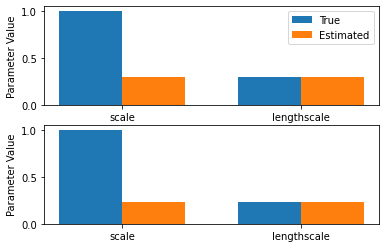

In [21]:
    kernelsParams = model.getKernelsParams()
    plot.svGPFA.plotUtils.getPlotTrueAndEstimatedKernelsParams(trueKernels=kernels, estimatedKernelsParams=kernelsParams)
    plt.show()

# Plot true and estimated latents means

In [ ]:
    tLatentsMeansFuncs = utils.svGPFA.configUtils.getLatentsMeansFuncs(nLatents=nLatents, nTrials=nTrials, config=simInitConfig)
    trialsTimes = utils.svGPFA.miscUtils.getTrialsTimes(trialsLengths=trialsLengths, dt=dtSimulate)
    tLatentsMeans = utils.svGPFA.miscUtils.getLatentsMeanFuncsSamples(latentsMeansFuncs=tLatentsMeansFuncs, trialsTimes=trialsTimes, dtype=C.dtype)
    with torch.no_grad(): latentsMeans, _ = model.predictLatents(newTimes=trialsTimes[0])
    trueLatentsMeans = simRes["latentsMeans"]
    trueLatentsSTDs = simRes["latentsSTDs"]
    trueLatentsSTDs = [trueLatentsSTDs[r][:nLatents,:] for r in range(nTrials)]

    plot.svGPFA.plotUtils.plotTrueAndEstimatedLatentsMeans(trueLatentsMeans=tLatentsMeans, estimatedLatentsMeans=latentsMeans, trialsTimes=trialsTimes)

# Plot true and estimated linear embedding parameters

In [ ]:
    with torch.no_grad(): estimatedC, estimatedD = model.getSVEmbeddingParams()
    plt.figure()
    plot.svGPFA.plotUtils.plotTrueAndEstimatedEmbeddingParams(trueC=C, trueD=d, estimatedC=estimatedC, estimatedD=estimatedD)


# Plot true and estimated CIF

In [ ]:
    title = "Trial {:d}, Neuron {:d}".format(trialToPlot, neuronToPlot)                                                                       
    # CIF
    T = torch.tensor(trialsLengths).max().item()
    oneTrialCIFTimes = torch.arange(0, T, dtCIF)
    cifTimes = torch.unsqueeze(torch.ger(torch.ones(nTrials), oneTrialCIFTimes), dim=2)
    with torch.no_grad(): cifValues = model.computeMeanCIFs(times=cifTimes)
    plt.figure()
    plot.svGPFA.plotUtils.plotSimulatedAndEstimatedCIFs(times=cifTimes[trialToPlot, :, 0], simCIFValues=simCIFsValues[trialToPlot][neuronToPlot], estCIFValues=cifValues[trialToPlot][neuronToPlot], title=title)

# KS time-rescaling GOF test -- numerical correction

In [ ]:
    gamma = 10 # number of resamples
    spikesTimesKS = spikesTimes[trialToPlot][neuronToPlot]
    cifTimesKS = cifTimes[trialToPlot,:,0]
    cifValuesKS = cifValues[trialToPlot][neuronToPlot]

    title = "Trial {:d}, Neuron {:d} ({:d} spikes)".format(trialToPlot, neuronToPlot, len(spikesTimesKS))

    diffECDFsX, diffECDFsY, estECDFx, estECDFy, simECDFx, simECDFy, cb = stats.pointProcess.tests.KSTestTimeRescalingNumericalCorrection(spikesTimes=spikesTimesKS, cifTimes=cifTimesKS, cifValues=cifValuesKS, gamma=gamma)
    plt.figure()
    plot.svGPFA.plotUtils.plotResKSTestTimeRescalingNumericalCorrection(diffECDFsX=diffECDFsX, diffECDFsY=diffECDFsY, estECDFx=estECDFx, estECDFy=estECDFy, simECDFx=simECDFx, simECDFy=simECDFy, cb=cb, title=title)

# KS time-rescaling GOF test -- analytical correction

In [ ]:
    t0 = math.floor(cifTimesKS.min())
    tf = math.ceil(cifTimesKS.max())
    dt = (cifTimesKS[1]-cifTimesKS[0]).item()
    utSRISIs, uCDF, cb, utRISIs = stats.pointProcess.tests.KSTestTimeRescalingAnalyticalCorrectionUnbinned(spikesTimes=spikesTimesKS, cifValues=cifValuesKS, t0=t0, tf=tf, dt=dt)
    sUTRISIs, _ = torch.sort(utSRISIs)

    plt.figure()
    plot.svGPFA.plotUtils.plotResKSTestTimeRescalingAnalyticalCorrection(sUTRISIs=sUTRISIs, uCDF=uCDF, cb=cb, title=title)


## Plot rescaled ISIs 1-lag scatter plot

In [ ]:
    plt.figure()
    plot.svGPFA.plotUtils.plotScatter1Lag(x=utRISIs, title=title)

## Plot rescaled ISIs autorocorrelogram

In [ ]:
    acfRes, confint = statsmodels.tsa.stattools.acf(x=utRISIs, unbiased=True, alpha=0.05)
    plt.figure()
    plot.svGPFA.plotUtils.plotACF(acf=acfRes, Fs=1/dt, confint=confint, title=title)

# ROC predictive analysis

In [ ]:
    pk = cifValuesKS*dtCIF
    bins = pd.interval_range(start=0, end=T, periods=len(pk))
    cutRes, _ = pd.cut(spikesTimesKS, bins=bins, retbins=True)
    Y = torch.from_numpy(cutRes.value_counts().values)
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(Y, pk, pos_label=1)
    roc_auc = sklearn.metrics.auc(fpr, tpr)
    plt.figure()
    plot.svGPFA.plotUtils.plotResROCAnalysis(fpr=fpr, tpr=tpr, auc=roc_auc, title=title)
